In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster import hierarchy
import matplotlib.ticker as mtick
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm
from sklearn import metrics

sns.set()

# ANÁLISE CLAUSTER

### Caso 1 - Considerano a média GERAL

In [ ]:
plt.rcParams.update({'font.size': 16})

Preparando os dados

In [ ]:
dir = 'https://raw.githubusercontent.com/josewilsonsouza/PBAER_UFRJ/main/'
df = pd.read_csv(dir+'DADOS_APP/DADOS_CURSOS.csv') # Dados que o app usa
df_com = pd.concat([pd.read_csv(dir+f'DADOS_ENSINO_SUPERIOR_UFRJ/UFRJ_DADOS_{ano}.csv') for ano in range(2010,2024)]) # pra pegar as areas dos cursos
df_area = df_com[['CO_CURSO','NO_CINE_AREA_GERAL']].drop_duplicates(keep='first', subset = 'CO_CURSO') # agora temos a area de cada curso

df = df.merge(df_area, on = 'CO_CURSO', how = 'left') # unindo com a area

In [ ]:
df

In [ ]:
df_agp = df.loc[:,['CO_CURSO', 'NO_CURSO', 'NU_ANO_CENSO', 'CENTRO','NO_CINE_AREA_GERAL','DURACAO','EVASAO','RETENCAO', 'SUCESSO']]
df_agp['CENTRO'] = df_agp['CENTRO'].replace('ESCOLA DE COMUNICACAO', 'EC') # renomeando escola de comunicação

Média geral de `EVASAO`, `RETENCAO` e `SUCESSO` por curso

In [ ]:
data = df_agp.loc[:,['CO_CURSO','EVASAO','RETENCAO', 'SUCESSO']].groupby('CO_CURSO').mean()

Correlação

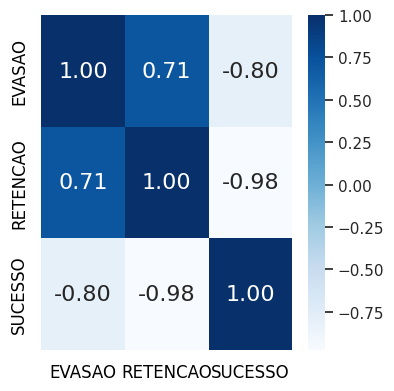

In [ ]:
plt.figure(figsize=(4.2, 4.2))
corr = np.corrcoef(data.values, rowvar=False)
plt.xticks(fontsize=12)  # Controla o tamanho das etiquetas do eixo x
plt.yticks(fontsize=12)
sns.heatmap(corr, annot=True, fmt='.2f', cbar=True, cmap='Blues', xticklabels=data.columns, yticklabels=data.columns);
plt.tight_layout()

plt.tick_params(axis='both',labelsize=12, labelcolor='black') # numeros em black
plt.savefig('heatmap.pdf')

Padronizando os dados

In [ ]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

Escolhendo um $k$ apropriado. Prmeiro plotamos o gráfico dos pontos para $k=4$

Para os dados escalados:

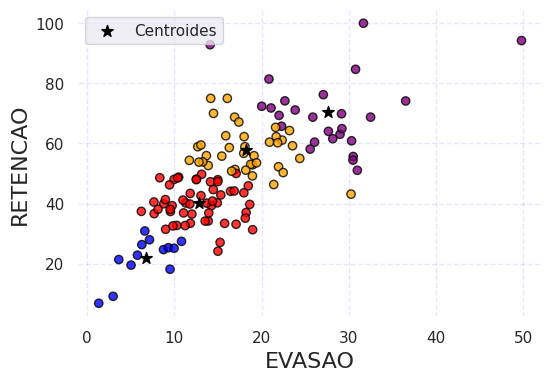

In [ ]:
km2 = KMeans(n_clusters=4, random_state = 42, n_init='auto').fit(data_scaled) # Testando k = 4
cores = ['red', 'purple', 'blue', 'orange','olive','orange','purple','brown']

centroids_scaled = km2.cluster_centers_ # centroides
centroids_original = scaler.inverse_transform(centroids_scaled) # centroides nos valores originais
data_original = scaler.inverse_transform(data_scaled) # escala original dos dados

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
x, y = data_original[:, data.columns.get_loc('EVASAO')], data_original[:, data.columns.get_loc('RETENCAO')]

ax.scatter(x, y, c=[cores[i] for i in km2.labels_], alpha=0.8, edgecolor='black')
ax.scatter(centroids_original[:, data.columns.get_loc('EVASAO')],
           centroids_original[:, data.columns.get_loc('RETENCAO')],
           c='black', s=75, marker='*', label='Centroides')

ax.set_xlabel('EVASAO', fontsize=16)
ax.set_ylabel('RETENCAO', fontsize=16)
fig.patch.set_facecolor('white')  # Fundo branco para a figura
ax.set_facecolor('white')  # Fundo branco para os eixos
ax.grid(True, linestyle='--', alpha=0.1, color='blue')
ax.legend()
plt.savefig('clusters.pdf')
plt.show()

Agora vamos usar outra medida que pode indicar um bom $k$

Coeficiente Silhueta

Para k = 2, coeficiente de silhueta médio = 0.4999
Para k = 3, coeficiente de silhueta médio = 0.4070
Para k = 4, coeficiente de silhueta médio = 0.3634
Para k = 5, coeficiente de silhueta médio = 0.3418
Para k = 6, coeficiente de silhueta médio = 0.3405
Para k = 7, coeficiente de silhueta médio = 0.3468
Para k = 8, coeficiente de silhueta médio = 0.3341
Para k = 9, coeficiente de silhueta médio = 0.3110


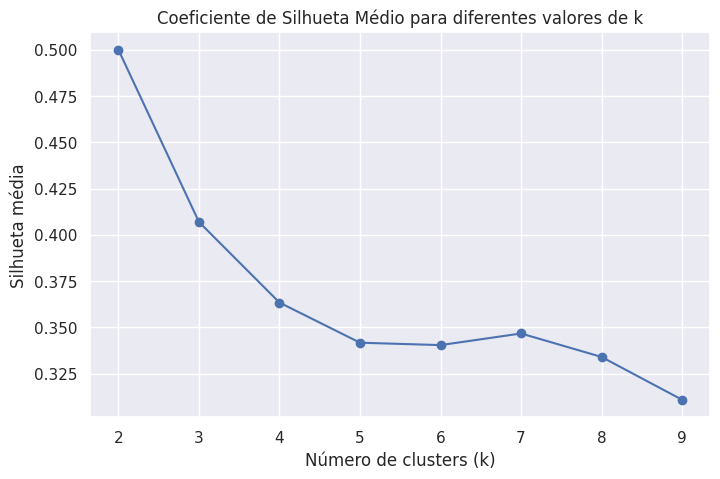

In [ ]:
range_n_clusters = range(2, 10)
silhouette_avg_scores = []
X = data_scaled
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_avg_scores.append(silhouette_avg)
    print(f"Para k = {n_clusters}, coeficiente de silhueta médio = {silhouette_avg:.4f}")

# Plot do coeficiente médio de silhueta para cada k
plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, silhouette_avg_scores, marker='o')
plt.title("Coeficiente de Silhueta Médio para diferentes valores de k")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Silhueta média")
plt.grid(True)
plt.show()

In [ ]:
df_geral = data.copy() # uma copia do data pra aplicar o kmeans

In [ ]:
k1, k2, k3 = 2, 3, 4
kmeans2, kmeans3, kmeans4 = [KMeans(n_clusters = k1, random_state = 42, n_init=10 ),
                             KMeans(n_clusters = k2, random_state = 42, n_init=10),
                             KMeans(n_clusters = k3, random_state = 42, n_init=10)]

df_geral = df_geral.assign(clusterk2 = kmeans2.fit_predict(data),
                           clusterk3 = kmeans3.fit_predict(data),
                           clusterk4 = kmeans4.fit_predict(data))

df_geral.reset_index(inplace = True)

In [ ]:
cols = ['CO_CURSO','NO_CURSO','CENTRO','DURACAO','NO_CINE_AREA_GERAL']
df_geral = df_geral.merge(df_agp.loc[:,cols].drop_duplicates(keep='first', subset = 'CO_CURSO'), on = 'CO_CURSO', how = 'left' ) # pra voltar a ter minhas colunas

In [ ]:
# esse código é pra ajustar os grupos/cluster, ordenando os Grupos de cluster de acordo com a distancia à origem
mean_ = lambda x,y: df_geral.query(f'clusterk4 == {y}')[x].mean()

m0 = np.sqrt(mean_('EVASAO',0)**2 + mean_('RETENCAO',0)**2) # metrica de distancia (ignorei o successo)
m1 = np.sqrt(mean_('EVASAO',1)**2 + mean_('RETENCAO',1)**2)
m2 = np.sqrt(mean_('EVASAO',2)**2 + mean_('RETENCAO',2)**2)
m3 = np.sqrt(mean_('EVASAO',3)**2 + mean_('RETENCAO',3)**2)

M = [m0,m1,m2,m3]
M1 = M.copy()

i0 = M.index(min(M))
i3 = M.index(max(M))
grupo0 = df_geral.query(f'clusterk4 == {i0}')
grupo3 = df_geral.query(f'clusterk4 == {i3}')

M.remove(min(M))
M.remove(max(M))

i1 = M1.index(min(M))
i2 = M1.index(max(M))

grupo1 = df_geral.query(f'clusterk4 == {i1}')
grupo2 = df_geral.query(f'clusterk4 == {i2}')

In [ ]:
len(grupo0), len(grupo1), len(grupo2), len(grupo3)

(17, 50, 45, 19)

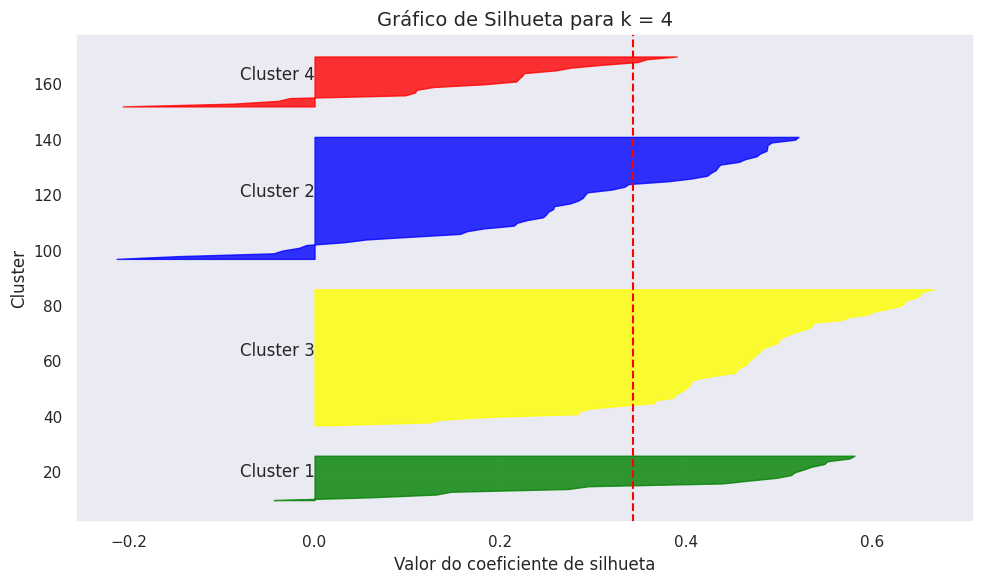

In [ ]:
# Aplica novamente o kmeans para garantir os mesmos rótulos
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(data)

# Distância dos centróides à origem
centroids = kmeans.cluster_centers_

# Mapear índice → ordem de cor e nome
cores = ['green', 'blue', 'yellow', 'red']
cluster_names = {
    i0: 'Cluster 1',
    i1: 'Cluster 2',
    i2: 'Cluster 3',
    i3: 'Cluster 4'
}

# Valores de silhueta
silhouette_vals = silhouette_samples(X, cluster_labels)
y_lower = 10

plt.figure(figsize=(10, 6))

for i in range(n_clusters):
    id_color = list(cluster_names.keys())[i]

    cluster_silhouette_vals = silhouette_vals[cluster_labels == id_color]
    cluster_silhouette_vals.sort()
    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i

    # Cor com base no índice ordenado
    cor = cores[id_color]
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, cluster_silhouette_vals,
                      facecolor=cor, edgecolor=cor, alpha=0.8)

    plt.text(-0.08, y_lower + 0.5 * size_cluster_i, cluster_names[i], fontsize=12)
    y_lower = y_upper + 10

# Linha da média
plt.axvline(x=np.mean(silhouette_vals), color="red", linestyle="--")

# Ajustes do gráfico
plt.title(f"Gráfico de Silhueta para k = {n_clusters}", fontsize=14)
plt.xlabel("Valor do coeficiente de silhueta", fontsize=12)
plt.ylabel("Cluster", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.2)
plt.tight_layout()
plt.savefig('grafico_silhueta.pdf')
plt.show()

In [ ]:
data = pd.merge(data, df_geral[cols], on = 'CO_CURSO', how = 'left').set_index('CO_CURSO') # unindo com o geral/ fiz isso para o caso de querer reescalar os dados em [0,1]

In [ ]:
data_CENTRO_GRUPO_0 = grupo0.groupby('CENTRO').agg({'EVASAO': 'mean', 'RETENCAO': 'mean', 'CO_CURSO': 'count'}).rename(columns={'CO_CURSO': 'Cluster 1'})
data_CENTRO_GRUPO_1 = grupo1.groupby('CENTRO').agg({'EVASAO': 'mean', 'RETENCAO': 'mean', 'CO_CURSO': 'count'}).rename(columns={'CO_CURSO': 'Cluster 2'})
data_CENTRO_GRUPO_2 = grupo2.groupby('CENTRO').agg({'EVASAO': 'mean', 'RETENCAO': 'mean', 'CO_CURSO': 'count'}).rename(columns={'CO_CURSO': 'Cluster 3'})
data_CENTRO_GRUPO_3 = grupo3.groupby('CENTRO').agg({'EVASAO': 'mean', 'RETENCAO': 'mean', 'CO_CURSO': 'count'}).rename(columns={'CO_CURSO': 'Cluster 4'})

In [ ]:
data_DURACAO_GRUPO_0 = grupo0.groupby('DURACAO').agg({'EVASAO': 'mean', 'RETENCAO': 'mean', 'CO_CURSO': 'count'}).rename(columns={'CO_CURSO': 'Cluster 1'})
data_DURACAO_GRUPO_1 = grupo1.groupby('DURACAO').agg({'EVASAO': 'mean', 'RETENCAO': 'mean', 'CO_CURSO': 'count'}).rename(columns={'CO_CURSO': 'Cluster 2'})
data_DURACAO_GRUPO_2 = grupo2.groupby('DURACAO').agg({'EVASAO': 'mean', 'RETENCAO': 'mean', 'CO_CURSO': 'count'}).rename(columns={'CO_CURSO': 'Cluster 3'})
data_DURACAO_GRUPO_3 = grupo3.groupby('DURACAO').agg({'EVASAO': 'mean', 'RETENCAO': 'mean', 'CO_CURSO': 'count'}).rename(columns={'CO_CURSO': 'Cluster 4'})

In [ ]:
data_AREA_GRUPO_0 = grupo0.groupby('NO_CINE_AREA_GERAL').agg({'EVASAO': 'mean', 'RETENCAO': 'mean', 'CO_CURSO': 'count'}).rename(columns={'CO_CURSO': 'Cluster 1'})
data_AREA_GRUPO_1 = grupo1.groupby('NO_CINE_AREA_GERAL').agg({'EVASAO': 'mean', 'RETENCAO': 'mean', 'CO_CURSO': 'count'}).rename(columns={'CO_CURSO': 'Cluster 2'})
data_AREA_GRUPO_2 = grupo2.groupby('NO_CINE_AREA_GERAL').agg({'EVASAO': 'mean', 'RETENCAO': 'mean', 'CO_CURSO': 'count'}).rename(columns={'CO_CURSO': 'Cluster 3'})
data_AREA_GRUPO_3 = grupo3.groupby('NO_CINE_AREA_GERAL').agg({'EVASAO': 'mean', 'RETENCAO': 'mean', 'CO_CURSO': 'count'}).rename(columns={'CO_CURSO': 'Cluster 4'})

In [ ]:
data_CENTROS_Clusters = pd.merge(data_CENTRO_GRUPO_0['Cluster 1'], data_CENTRO_GRUPO_1['Cluster 2'], on='CENTRO',  how='outer')
data_CENTROS_Clusters = pd.merge(data_CENTROS_Clusters, data_CENTRO_GRUPO_2['Cluster 3'], on='CENTRO',  how='outer')
data_CENTROS_Clusters = pd.merge(data_CENTROS_Clusters, data_CENTRO_GRUPO_3['Cluster 4'], on='CENTRO',  how='outer')
data_CENTROS_Clusters = data_CENTROS_Clusters.fillna(0).astype(int)

In [ ]:
data_DURACOES_Clusters = pd.merge(data_DURACAO_GRUPO_0['Cluster 1'], data_DURACAO_GRUPO_1['Cluster 2'], on='DURACAO',  how='outer')
data_DURACOES_Clusters = pd.merge(data_DURACOES_Clusters, data_DURACAO_GRUPO_2['Cluster 3'], on='DURACAO',  how='outer')
data_DURACOES_Clusters = pd.merge(data_DURACOES_Clusters, data_DURACAO_GRUPO_3['Cluster 4'], on='DURACAO',  how='outer')
data_DURACOES_Clusters = data_DURACOES_Clusters.fillna(0).astype(int)

In [ ]:
data_AREAS_Clusters = pd.merge(data_AREA_GRUPO_0['Cluster 1'], data_AREA_GRUPO_1['Cluster 2'], on='NO_CINE_AREA_GERAL',  how='outer')
data_AREAS_Clusters = pd.merge(data_AREAS_Clusters, data_AREA_GRUPO_2['Cluster 3'], on='NO_CINE_AREA_GERAL',  how='outer')
data_AREAS_Clusters = pd.merge(data_AREAS_Clusters, data_AREA_GRUPO_3['Cluster 4'], on='NO_CINE_AREA_GERAL',  how='outer')
data_AREAS_Clusters = data_AREAS_Clusters.fillna(0).astype(int)
data_AREAS_Clusters = data_AREAS_Clusters.replace('0', '')

In [ ]:
def plot_save_barra(tipo):
  if tipo == 'CENTROS':
    data = data_CENTROS_Clusters
  elif tipo == 'DURACAO':
    data = data_DURACOES_Clusters
  elif tipo == 'AREAS':
    data = data_AREAS_Clusters

  tipo_dic = {'CENTROS': 'Centro', 'DURACAO': 'Duração', 'AREAS': 'Área'}
  tipo_tit = {'CENTROS': 'Quantidade de Cursos por Centro', 'DURACAO': 'Quantidade de Cursos por Duração', 'AREAS': 'Quantidade de Cursos por Área'}
  tipo_nome = {'CENTROS': 'qtd_cursos_centro.pdf', 'DURACAO': 'qtd_cursos_duracao.pdf', 'AREAS': 'qtd_cursos_area.pdf'}

  cores = ['green','blue', 'orange', 'red']

  ax = data[['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']].plot(kind='bar', figsize=(16, 7), color=cores)

  for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=12, color='black')

  #plt.title(f'Quantidade de Cursos por {tipo_dic[tipo]}', fontsize=20, color='black')
  plt.xlabel(f'{tipo_dic[tipo]}', fontsize=16, color='black')
  plt.ylabel('Número de Cursos', fontsize=16, color='k')
  plt.xticks(rotation=45, ha='right')
  plt.tight_layout()

  ax.tick_params(axis='both', labelsize=16, labelcolor='black')  # Números em preto
  fig = plt.gcf()  # Obter a figura associada aos eixos
  fig.patch.set_facecolor('white')  # Fundo branco para a figura
  ax.set_facecolor('white')  # Fundo branco para os eixos
  ax.grid(True, linestyle='-', alpha=0.2, color='blue')
  ax.legend(title='Clusters', fontsize=16)

  plt.savefig(tipo_nome[tipo])
  plt.show()

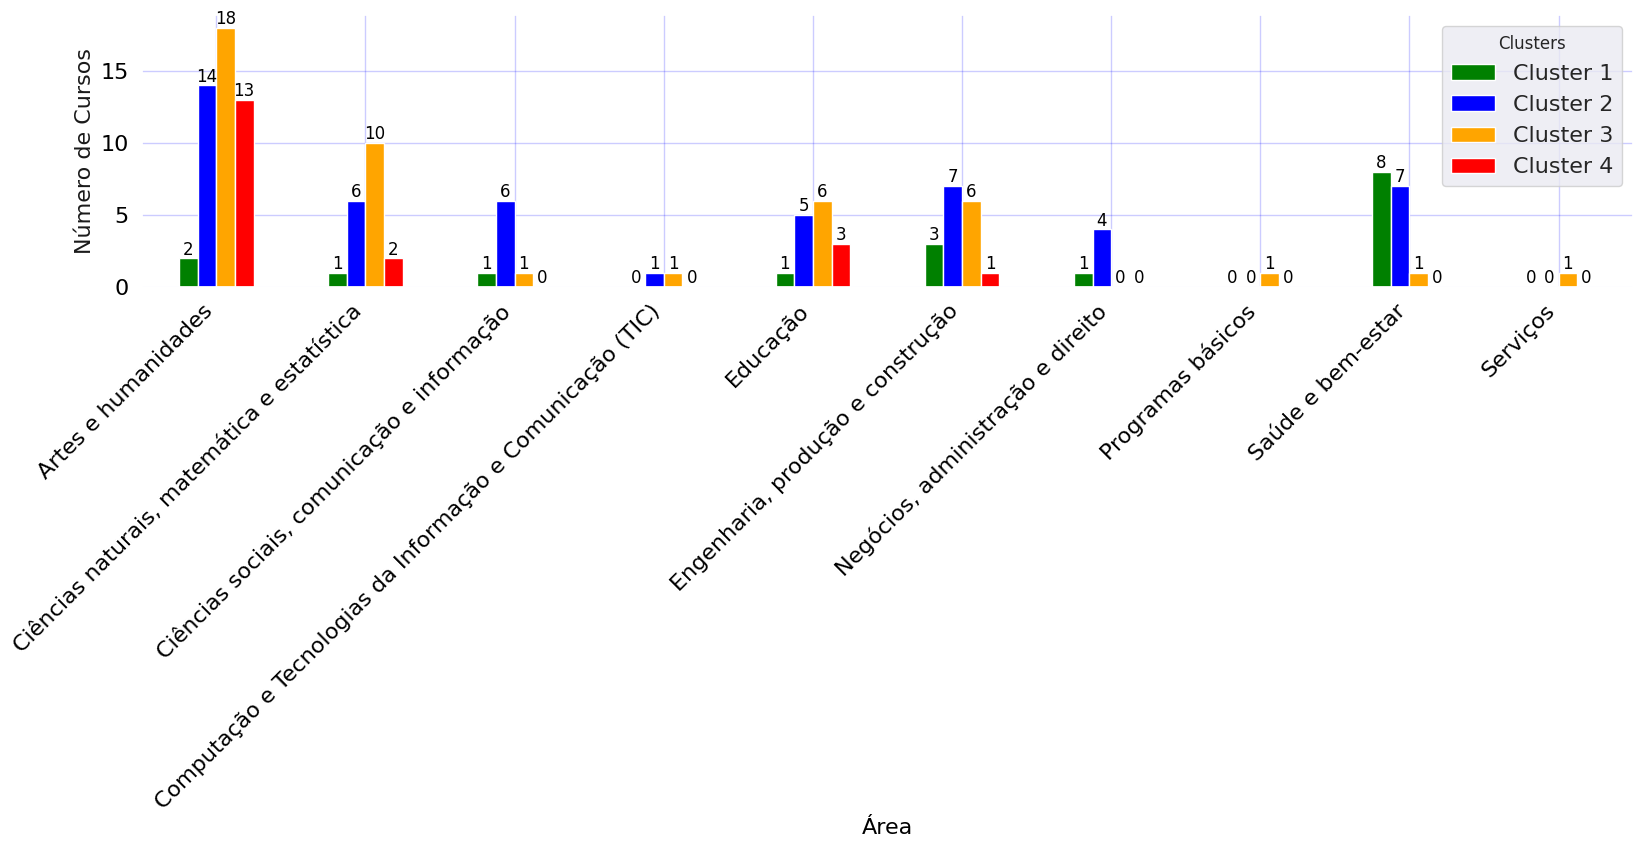

In [ ]:
plot_save_barra('AREAS')

In [ ]:
grupos = [grupo0, grupo1, grupo2, grupo3]
N = [len(grupo) for grupo in grupos]
med_Eva = [grupo['EVASAO'].mean() for grupo in grupos]
med_Ret = [grupo['RETENCAO'].mean() for grupo in grupos]
med_Suc = [grupo['SUCESSO'].mean() for grupo in grupos]
std_Eva = [grupo['EVASAO'].std() for grupo in grupos]
std_Ret = [grupo['RETENCAO'].std() for grupo in grupos]
std_Suc = [grupo['SUCESSO'].std() for grupo in grupos]
median_Eva = [grupo['EVASAO'].median() for grupo in grupos]
median_Ret = [grupo['RETENCAO'].median() for grupo in grupos]
median_Suc = [grupo['SUCESSO'].median() for grupo in grupos]
max_Eva = [grupo['EVASAO'].max() for grupo in grupos]
max_Ret = [grupo['RETENCAO'].max() for grupo in grupos]
max_Suc = [grupo['SUCESSO'].max() for grupo in grupos]
min_Eva = [grupo['EVASAO'].min() for grupo in grupos]
min_Ret = [grupo['RETENCAO'].min() for grupo in grupos]
min_Suc = [grupo['SUCESSO'].min() for grupo in grupos]

In [ ]:
df_Eva = pd.DataFrame({
    'Cluster': ['1', '2', '3', '4'],
    'N': N,
    'Média': med_Eva,
    'Mediana': median_Eva,
    'D.P': std_Eva,
    'Max': max_Eva,
    'Min': min_Eva
    })

df_Ret = pd.DataFrame({
    'Média': med_Ret,
    'Mediana': median_Ret,
    'D.P': std_Ret,
    'Max': max_Ret,
    'Min': min_Ret
    })

In [ ]:
df_Ret.to_latex('ret.tex', index=False, escape=False, float_format='%.2f')
df_Eva.to_latex('eva.tex', index=False, escape=False, float_format='%.2f')

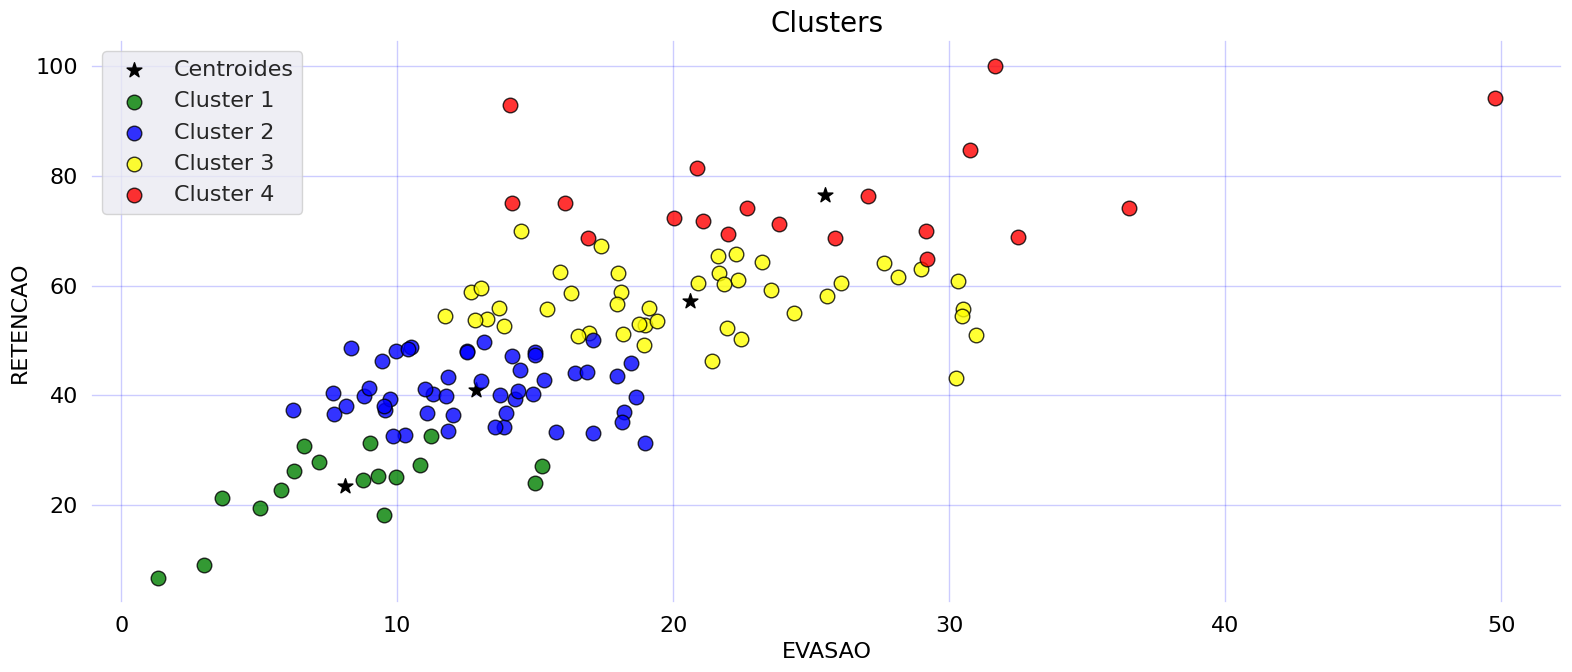

In [ ]:
fig, ax = plt.subplots(figsize=(16, 7))

# Aplicação do KMeans
km = kmeans4.fit(data)  # k = 4
x, y = data['EVASAO'], data['RETENCAO']
cores = ['green','blue','yellow', 'red']

# Nomear os clusters
cluster_names = {
    i0: 'Cluster 1',
    i1: 'Cluster 2',
    i2: 'Cluster 3',
    i3: 'Cluster 4'
}

# Pegar os centróides do KMeans
centroids = km.cluster_centers_

# Plotar os centróides
ax.scatter(
    centroids[:, 0], centroids[:, 1],
    c='black', s=125, marker='*', label='Centroides'
)

# Plotar os dados
for i in range(4):
    id_color = list(cluster_names.keys())[i]
    mask = km.labels_ == i
    ax.scatter(
        x[mask], y[mask],
        c=cores[id_color], s=110, alpha=0.8, edgecolor='black',
        label=cluster_names[i]
    )

# Configurações adicionais
ax.set_xlabel('EVASAO', fontsize=16, color="black")
ax.set_ylabel('RETENCAO', fontsize=16, color='black')
ax.tick_params(axis='both', labelsize=16, labelcolor='black')  # Números em preto
fig.patch.set_facecolor('white')  # Fundo branco para a figura
ax.set_facecolor('white')  # Fundo branco para os eixos
ax.grid(True, linestyle='-', alpha=0.2, color='blue')
ax.set_title('Clusters', fontsize=20, color='black')

handles, labels = ax.get_legend_handles_labels()
sorted_handles_labels = sorted(zip(handles, labels), key=lambda x: x[1])  # Ordena pelas labels
handles, labels = zip(*sorted_handles_labels)  # Separa os handles e labels novamente
ax.legend(handles, labels, fontsize=16)
plt.tight_layout()

# Salvar o gráfico como PDF
plt.savefig('clusters.pdf')
plt.show()


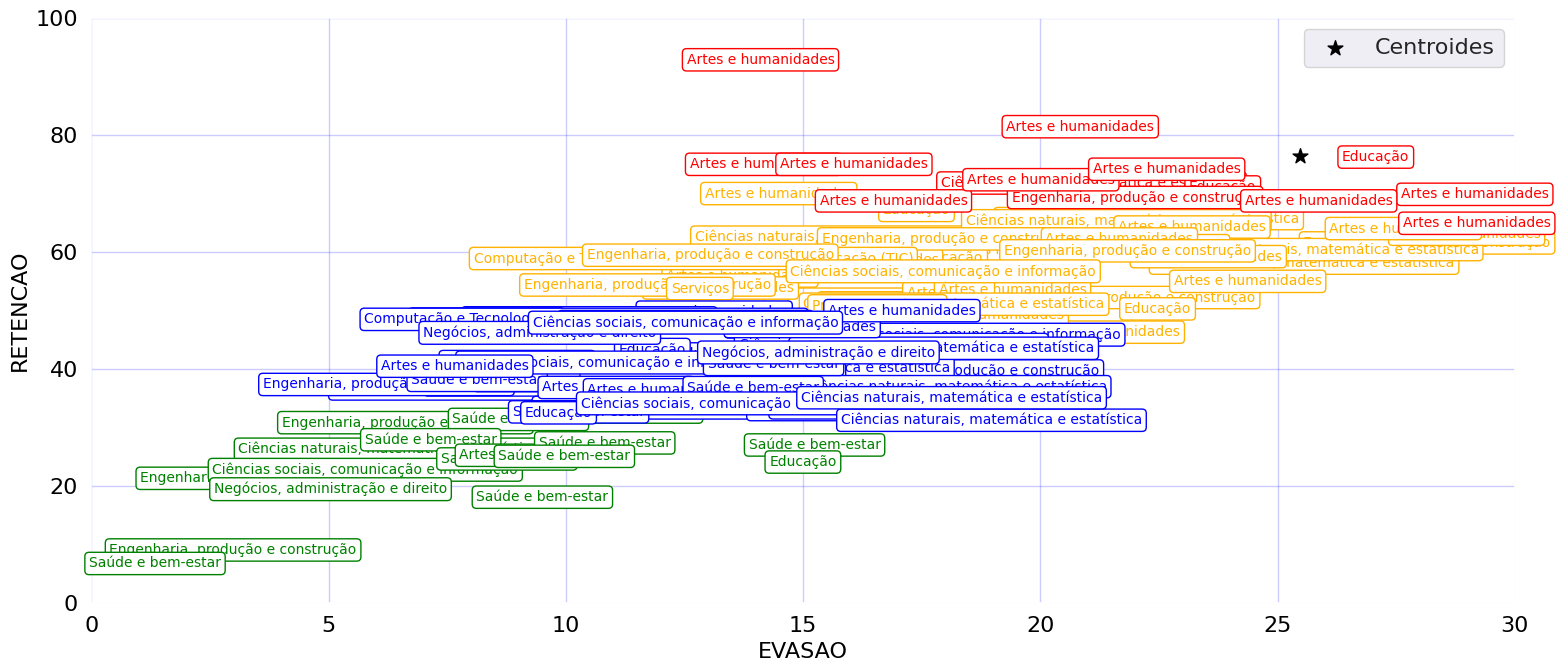

In [ ]:
fig, ax = plt.subplots(figsize=(16, 7))

# Aplicação do KMeans
km = KMeans(n_clusters=4, random_state=42, n_init=10).fit(data[['EVASAO','RETENCAO','SUCESSO']])  # k = 4
x, y = data['EVASAO'], data['RETENCAO']
cores = ['green','blue','#FFB300', 'red']

# Nomear os clusters
cluster_names = {
    i0: 'Cluster 1',
    i1: 'Cluster 2',
    i2: 'Cluster 3',
    i3: 'Cluster 4'
}

# Pegar os centróides do KMeans
centroids = km.cluster_centers_

# Plotar os centróides
ax.scatter(
    centroids[:, 0], centroids[:, 1],
    c='black', s=125, marker='*', label='Centroides'
)

# Substituir os pontos pelos nomes dos cursos
cursos = data['NO_CINE_AREA_GERAL']  # Supondo que os nomes dos cursos estão nesta coluna
for i in range(4):
    mask = km.labels_ == i
    id_color = list(cluster_names.keys())[i]
    for xi, yi, nome in zip(x[mask], y[mask], cursos[mask]):
        ax.annotate(
            nome, (xi, yi),
            color=cores[id_color], fontsize=10, ha='center', va='center',
            bbox=dict(facecolor='white', edgecolor=cores[id_color], boxstyle='round,pad=0.3')
        )

# Configurações adicionais
ax.set_xlim(0, 30)  # Limite do eixo X
ax.set_ylim(0, 100)
ax.set_xlabel('EVASAO', fontsize=16, color="black")
ax.set_ylabel('RETENCAO', fontsize=16, color='black')
ax.tick_params(axis='both', labelsize=16, labelcolor='black')  # Números em preto
fig.patch.set_facecolor('white')  # Fundo branco para a figura
ax.set_facecolor('white')  # Fundo branco para os eixos
ax.grid(True, linestyle='-', alpha=0.2, color='blue')
#ax.set_title('Clusters', fontsize=20, color='black')
ax.legend(fontsize=16)  # Legenda com nomes personalizados
plt.tight_layout()

# Salvar o gráfico como PDF
plt.savefig('cursos_clusters_1_2.pdf')
plt.show()


### Caso 2 - Considerando cada ano individualmente

In [ ]:
cotovelo = {'kas':list(range(1,16))}
vars = ['EVASAO', 'RETENCAO', 'SUCESSO']

for a in range(2015, 2023):
  df_ano = df_agp.loc[df_agp.NU_ANO_CENSO == a].dropna()
  #df_ano.iloc[:, :] = StandardScaler().fit_transform(df_ano)
  inercias = []
  for k in range(1,16): # teste do cotovelo
    kmeans = KMeans(n_clusters = k, random_state=0, n_init=10).fit(df_ano[vars])
    inercias.append(kmeans.inertia_)
  cotovelo[f'inertias{a}'] = inercias

In [ ]:
teste_cot = pd.DataFrame(cotovelo)

In [ ]:
silhueta = {'kas':list(range(2,16))}

for a in range(2015, 2023):
  df_ano = df_agp.loc[df_agp.NU_ANO_CENSO == a].dropna()
  #df_ano.iloc[:, :] = StandardScaler().fit_transform(df_ano)
  inercias = []
  for k in range(2,16): # teste do cotovelo
    kmeans = KMeans(n_clusters = k, random_state=0, n_init=42).fit(df_ano[vars])
    inercias.append(metrics.silhouette_score(df_ano[vars], kmeans.labels_))
  silhueta[f'score{a}'] = inercias

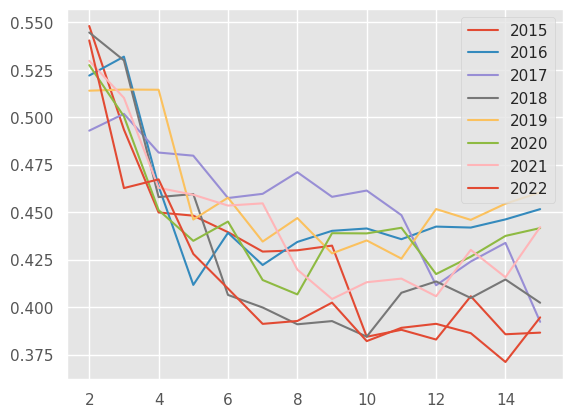

In [ ]:
for ano in range(2015,2023):
  plt.plot(range(2,16), teste_silhueta[f'score{ano}'], label = f'{ano}')
  plt.legend()

In [ ]:
df15,df16,df17,df18,df19,df20,df21,df22,d23 = [df_agp.query(f'NU_ANO_CENSO == {a}').dropna().reset_index(drop=True) for a in range(2015,2024)]

In [ ]:
k = 4
dfs_clts = []
for dfi in [df15,df16,df17,df18,df19,df20,df21,df22,d23]:
  dfi_prev = dfi.loc[:,['CO_CURSO','EVASAO','RETENCAO', 'SUCESSO']].set_index('CO_CURSO')
  kmeans4 = KMeans(n_clusters = k, random_state = 42, n_init=10)
  dfi_prev = dfi_prev.assign(clusterk4 = kmeans4.fit_predict(dfi_prev))
  dfi_prev = dfi_prev.merge(dfi[['CO_CURSO',"NO_CURSO",'NU_ANO_CENSO','DURACAO','CENTRO','NO_CINE_AREA_GERAL']], on = 'CO_CURSO', how = 'right')
  dfs_clts.append(dfi_prev)

In [ ]:
dfs_clts[0].head()

,CO_CURSO,EVASAO,RETENCAO,SUCESSO,clusterk4,NO_CURSO,NU_ANO_CENSO,DURACAO,CENTRO,NO_CINE_AREA_GERAL
0,121706,7.352941,39.248353,48.275862,2,CIÊNCIAS BIOLÓGICAS: BIOFÍSICA,2015,4.0,CAXIAS,"Ciências naturais, matemática e estatística"
1,1114292,22.789116,56.979291,31.182796,2,CIÊNCIAS BIOLÓGICAS: BIOTECNOLOGIA,2015,4.0,CAXIAS,"Ciências naturais, matemática e estatística"
2,1114291,0.000000,46.218487,38.095238,2,NANOTECNOLOGIA,2015,4.0,CAXIAS,"Ciências naturais, matemática e estatística"
3,99287,19.411765,0.000000,100.000000,3,CIÊNCIAS BIOLÓGICAS,2015,5.0,MACAE,Educação
4,121848,25.988701,70.187500,22.500000,1,ENFERMAGEM E OBSTETRÍCIA,2015,5.0,MACAE,Saúde e bem-estar


In [ ]:
df_alternancia = pd.DataFrame()

for i in range(len(dfs_clts) - 1):
    df_atual = dfs_clts[i]
    df_proximo = dfs_clts[i + 1]


    df_semelhantes_prev = []
    for curso in df_atual['CO_CURSO'].unique():
      cluster_curso = df_atual.loc[df_atual['CO_CURSO'] == curso, 'clusterk4'].iloc[0]
      df_cluster_curso = df_atual.query(f'clusterk4 == {cluster_curso}')
      df_semelhantes_prev += [(curso, df_cluster_curso.CO_CURSO.unique().tolist())]

    df_semelhantes_atual = []
    for curso in df_proximo['CO_CURSO'].unique():
      cluster_curso = df_proximo.loc[df_proximo['CO_CURSO'] == curso, 'clusterk4'].iloc[0]
      df_cluster_curso = df_proximo.query(f'clusterk4 == {cluster_curso}')
      df_semelhantes_atual += [(curso, df_cluster_curso.CO_CURSO.unique().tolist())]

    for curso in df_atual['CO_CURSO'].unique():
      if curso in df_proximo['CO_CURSO'].unique():
        for i in df_semelhantes_atual:
          if curso == i[0]:
            s_atual = i[1]
            for j in df_semelhantes_prev:
              if curso == j[0]:
                s_prev = j[1]
                N = 0
                for s in s_atual:
                  if s in s_prev:
                    N += 1
                ano = df_proximo.loc[df_proximo['CO_CURSO'] == curso, 'NU_ANO_CENSO'].iloc[0]
                df_alternancia = pd.concat([df_alternancia, pd.DataFrame({'NU_ANO_CENSO': [ano], 'CO_CURSO': [curso], 'iguais_ano_anterior': [(N-1)/len(s_prev)]})])
      else:
        continue


df_alternancia.reset_index(drop=True, inplace=True)

In [ ]:
df_alt = df_alternancia.merge(df_agp.loc[:,['CO_CURSO','NO_CURSO','CENTRO','NO_CINE_AREA_GERAL','DURACAO','NU_ANO_CENSO']], on = ['CO_CURSO','NU_ANO_CENSO'], how = 'inner')

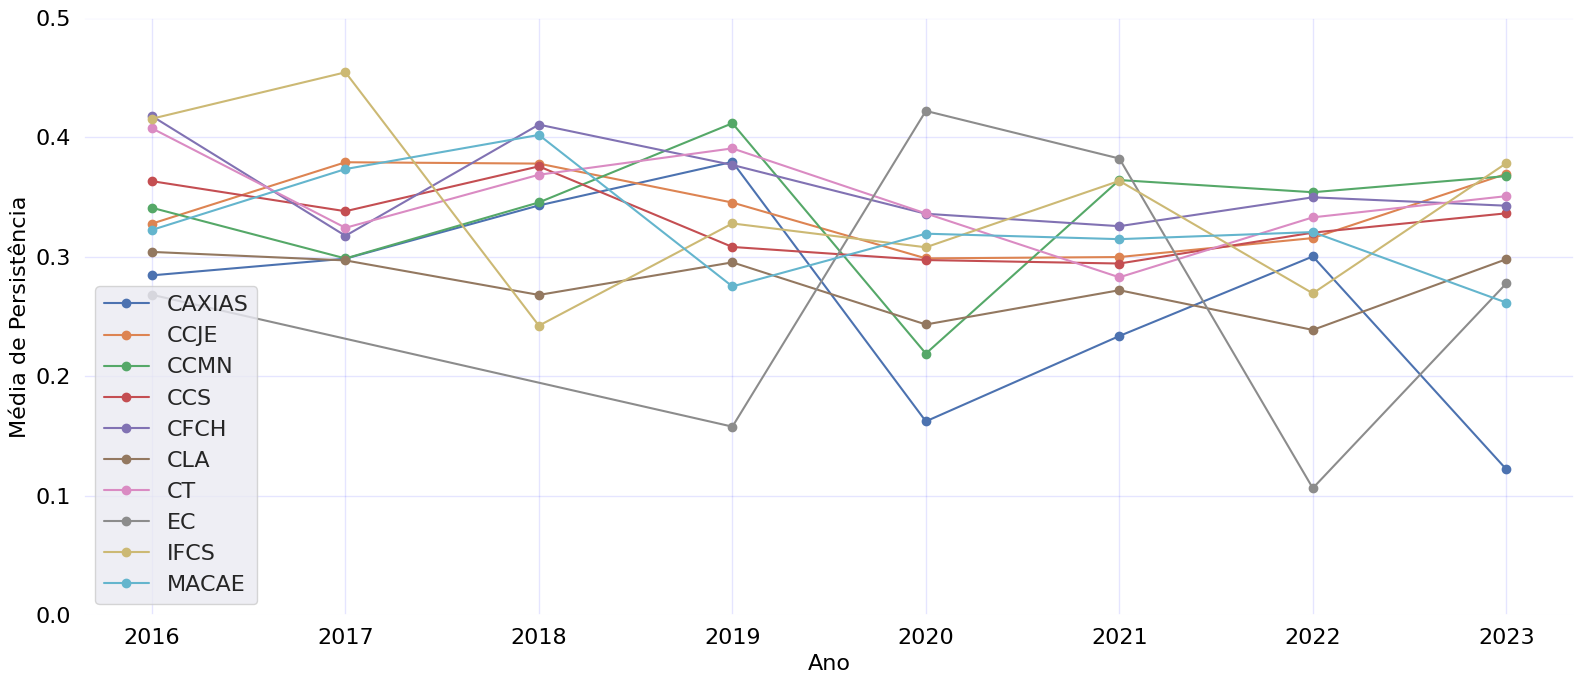

In [ ]:
media_alt_centro_ano = df_alt.groupby(['CENTRO','NU_ANO_CENSO']).agg(iguais_ano_anterior=('iguais_ano_anterior', 'mean'))

fig, ax = plt.subplots(figsize=(16, 7))

for centro in media_alt_centro_ano.index.get_level_values(0).unique():
    data_centro = media_alt_centro_ano.loc[centro]
    ax.plot(data_centro.index, data_centro['iguais_ano_anterior'],'o-', label=centro)
    ax.set_ylim(0, .5)
    ax.set_xlabel('Ano', fontsize=16, color='black')
    ax.set_ylabel('Média de Persistência', fontsize=16, color='black')
    ax.tick_params(axis='both', labelsize=16, labelcolor='black')
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    #ax.set_title('Média de Persistência de Clusters entre Anos Consecutivos por Centro', fontsize=20, color='black')
    ax.grid(True, linestyle='-', alpha=0.1, color='blue')
    ax.legend(fontsize=16)
    fig.tight_layout()

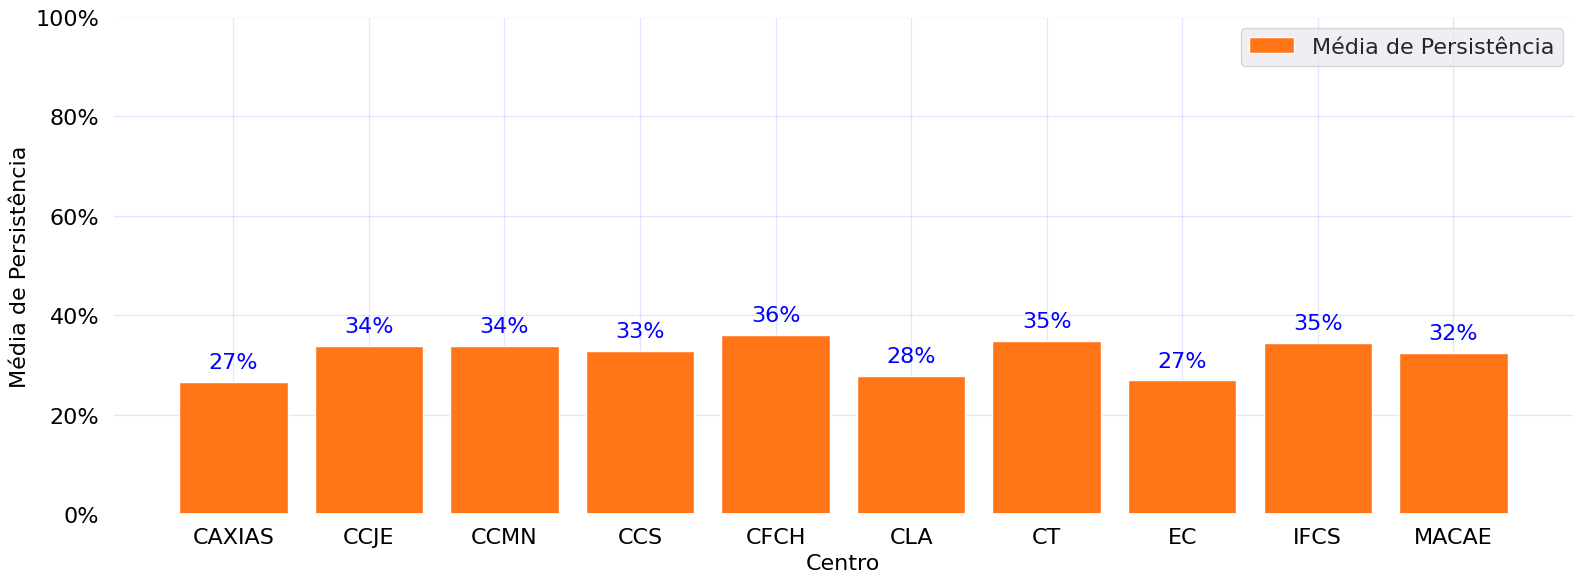

In [ ]:
# Calcular o desvio padrão por ano
media_alt = df_alt.groupby(['CENTRO']).agg(
    iguais_ano_anterior=('iguais_ano_anterior', 'mean'),
    std=('iguais_ano_anterior', 'std'))

# Preencher valores NaN de desvio padrão com 0 (se necessário)
media_alt['std'] = media_alt['std'].fillna(0)

# Definir valores mínimos e máximos para a sombra usando o desvio padrão
media_alt['min'] = media_alt['iguais_ano_anterior'] - media_alt['std']
media_alt['max'] = media_alt['iguais_ano_anterior'] + media_alt['std']

# Garantir que os valores estão no intervalo [0, 1]
media_alt['min'] = media_alt['min'].clip(lower=0)
media_alt['max'] = media_alt['max'].clip(upper=1)

# Criar o gráfico
fig, ax = plt.subplots(figsize=(16, 6))

# Adicionar a sombra ao redor da linha
#ax.fill_between(
#    media_alt.index, media_alt['min'], media_alt['max'],
#    color='blue', alpha=0.1, label='Desvio Padrão'
#)

# Plotar a linha com os dados
ax.bar(
    media_alt.index, media_alt['iguais_ano_anterior'],
    linestyle='-', label='Média de Persistência', color='#FF7518'
)

# Adicionar os rótulos nos pontos
for ano, valor in zip(media_alt.index, media_alt['iguais_ano_anterior']):
    ax.annotate(
        f'{valor:.0%}',  # Formata o valor como porcentagem com 1 casa decimal
        (ano, valor),
        textcoords="offset points", xytext=(0, 10), ha='center', fontsize=16, color='blue'
    )

# Configurar o eixo Y em porcentagem
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))

# Configurações do gráfico
ax.set_ylim(0, 1)
ax.set_xlabel('Centro', fontsize=16, color='black')
ax.tick_params(axis='both', labelsize=16, labelcolor='black')
ax.set_ylabel('Média de Persistência', fontsize=16, color='black')
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
#ax.set_title('Média de Persistência de Clusters por Centro', fontsize=16, color='black')
ax.grid(True, linestyle='-', alpha=0.1, color='blue')
ax.set_xticks(media_alt.index)  # Define os ticks no eixo x com os anos
ax.legend(fontsize=16)  # Adiciona a legenda
fig.tight_layout()

# Salvar o gráfico como PDF
plt.savefig('media_persistencia_centros.pdf')
plt.show()

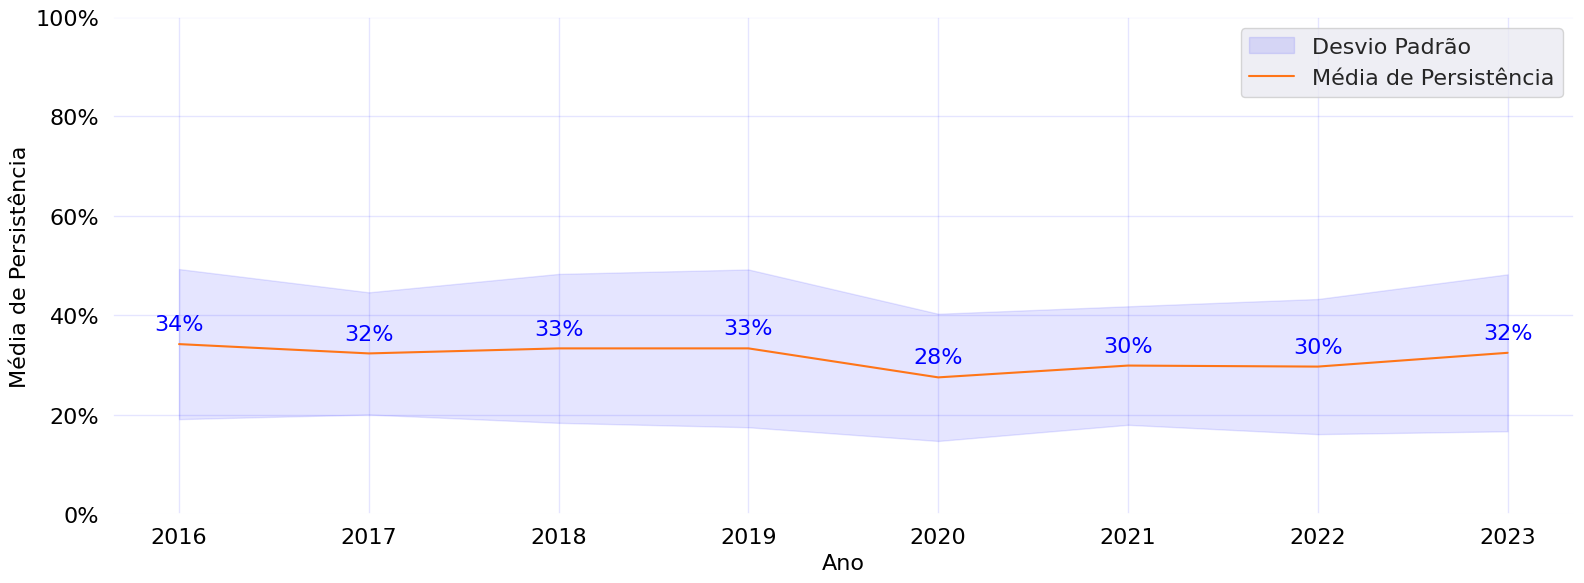

In [ ]:
# Calcular o desvio padrão por ano
media_alt = df_alt.groupby(['NU_ANO_CENSO']).agg(
    iguais_ano_anterior=('iguais_ano_anterior', 'mean'),
    std=('iguais_ano_anterior', 'std'))

# Preencher valores NaN de desvio padrão com 0 (se necessário)
media_alt['std'] = media_alt['std'].fillna(0)

# Definir valores mínimos e máximos para a sombra usando o desvio padrão
media_alt['min'] = media_alt['iguais_ano_anterior'] - media_alt['std']
media_alt['max'] = media_alt['iguais_ano_anterior'] + media_alt['std']

# Garantir que os valores estão no intervalo [0, 1]
media_alt['min'] = media_alt['min'].clip(lower=0)
media_alt['max'] = media_alt['max'].clip(upper=1)

# Criar o gráfico
fig, ax = plt.subplots(figsize=(16, 6))

# Plotar a linha com os dados

# Adicionar a sombra ao redor da linha
ax.fill_between(
    media_alt.index, media_alt['min'], media_alt['max'],
    color='blue', alpha=0.1, label='Desvio Padrão'
)

ax.plot(
    media_alt.index, media_alt['iguais_ano_anterior'],
    linestyle='-', label='Média de Persistência', color='#FF7518'
)

# Adicionar os rótulos nos pontos
for ano, valor in zip(media_alt.index, media_alt['iguais_ano_anterior']):
    ax.annotate(
        f'{valor:.0%}',  # Formata o valor como porcentagem com 1 casa decimal
        (ano, valor),
        textcoords="offset points", xytext=(0, 10), ha='center', fontsize=16, color='blue'
    )

# Configurar o eixo Y em porcentagem
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))

# Configurações do gráfico
ax.set_ylim(0, 1)
ax.set_xlabel('Ano', fontsize=16, color='black')
ax.tick_params(axis='both', labelsize=16, labelcolor='black')
ax.set_ylabel('Média de Persistência', fontsize=16, color='black')
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
#ax.set_title('Média de Persistência de Clusters por Centro', fontsize=16, color='black')
ax.grid(True, linestyle='-', alpha=0.1, color='blue')
ax.set_xticks(media_alt.index)  # Define os ticks no eixo x com os anos
ax.legend(fontsize=16)  # Adiciona a legenda
fig.tight_layout()

# Salvar o gráfico como PDF
plt.savefig('media_persistencia_anos.pdf')
plt.show()

In [ ]:
media_alt['iguais_ano_anterior'].mean()

np.float64(0.31608227729564886)

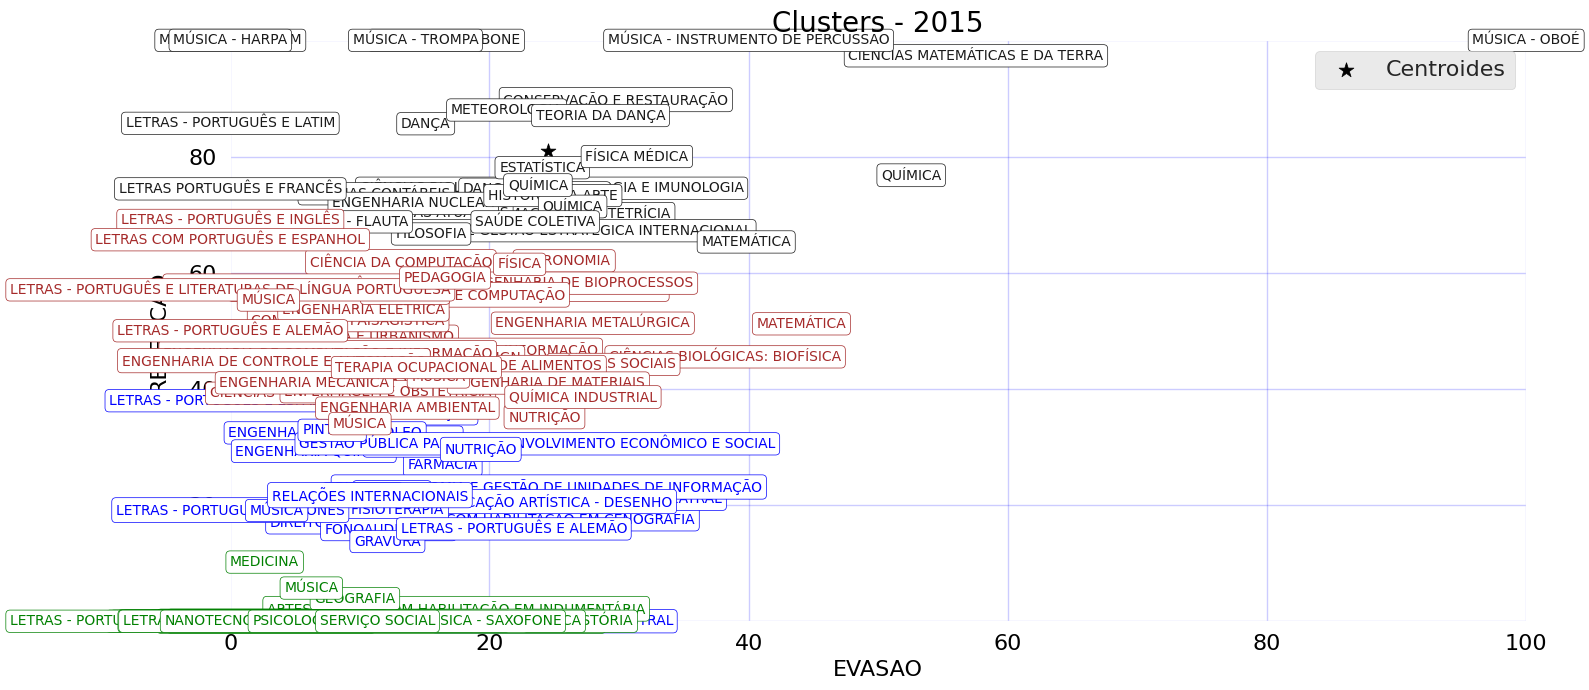

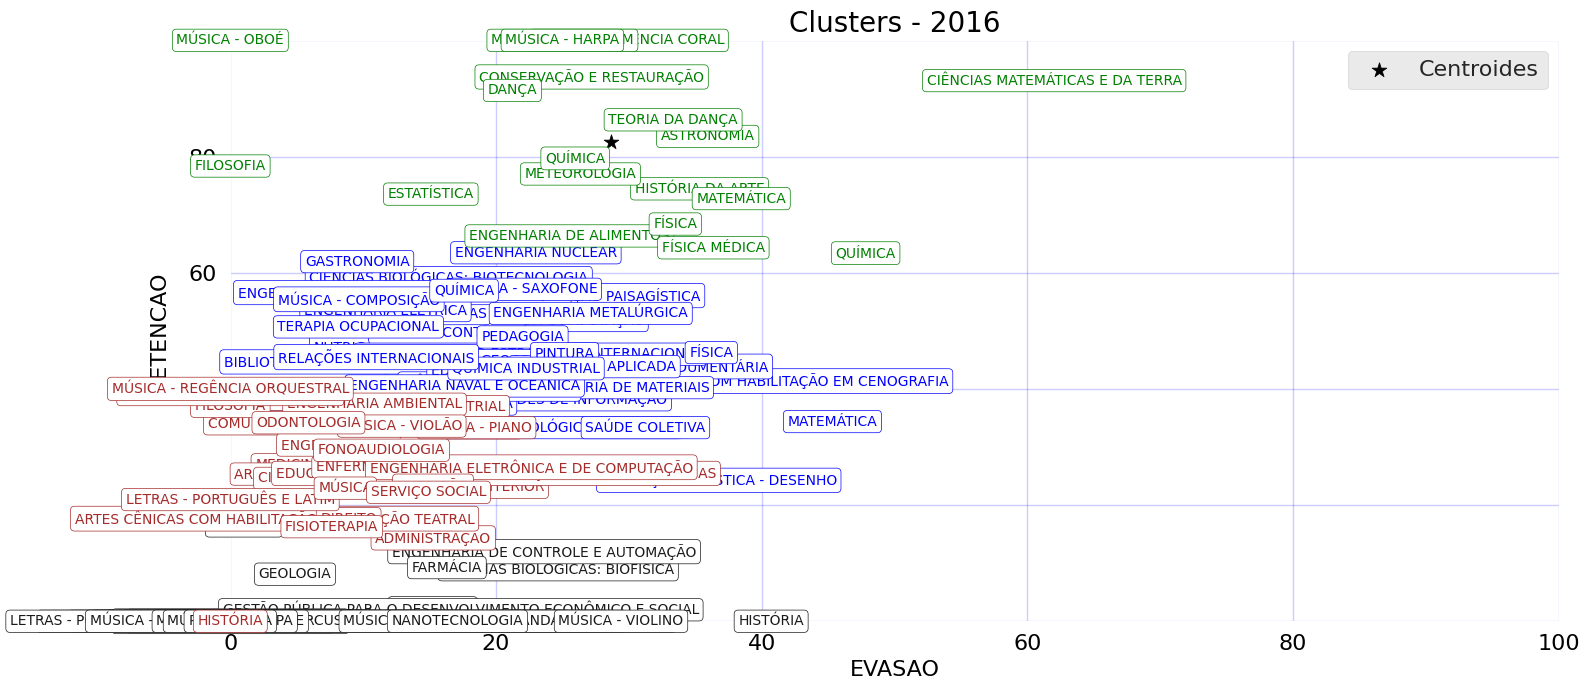

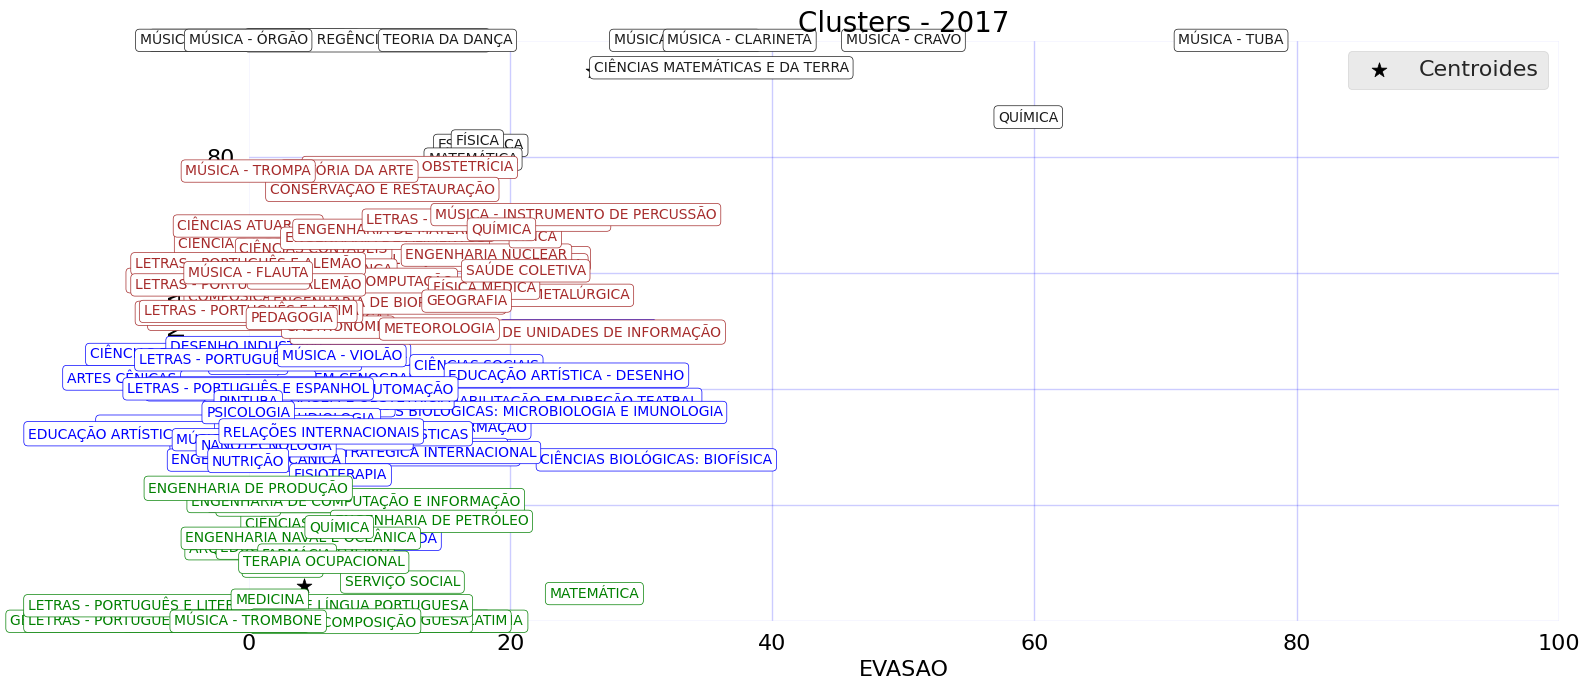

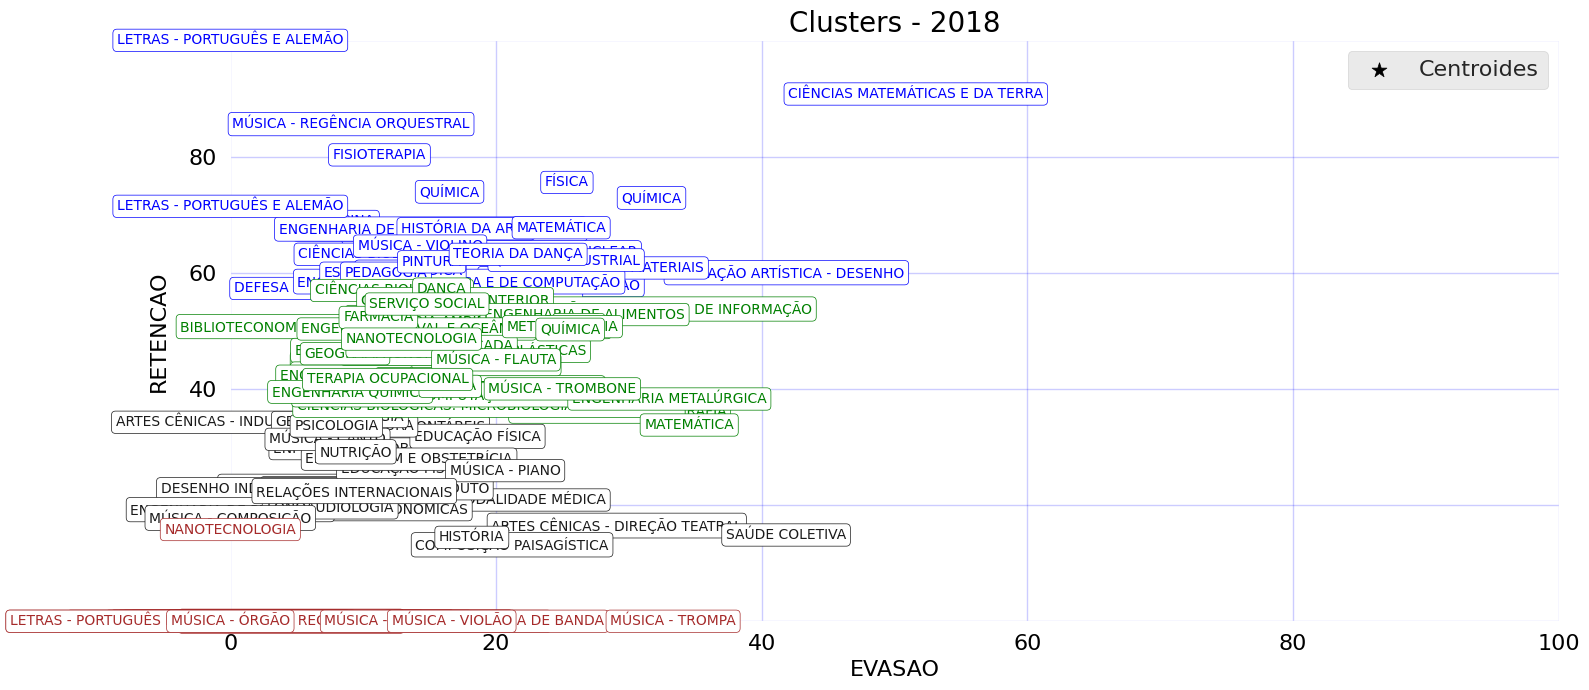

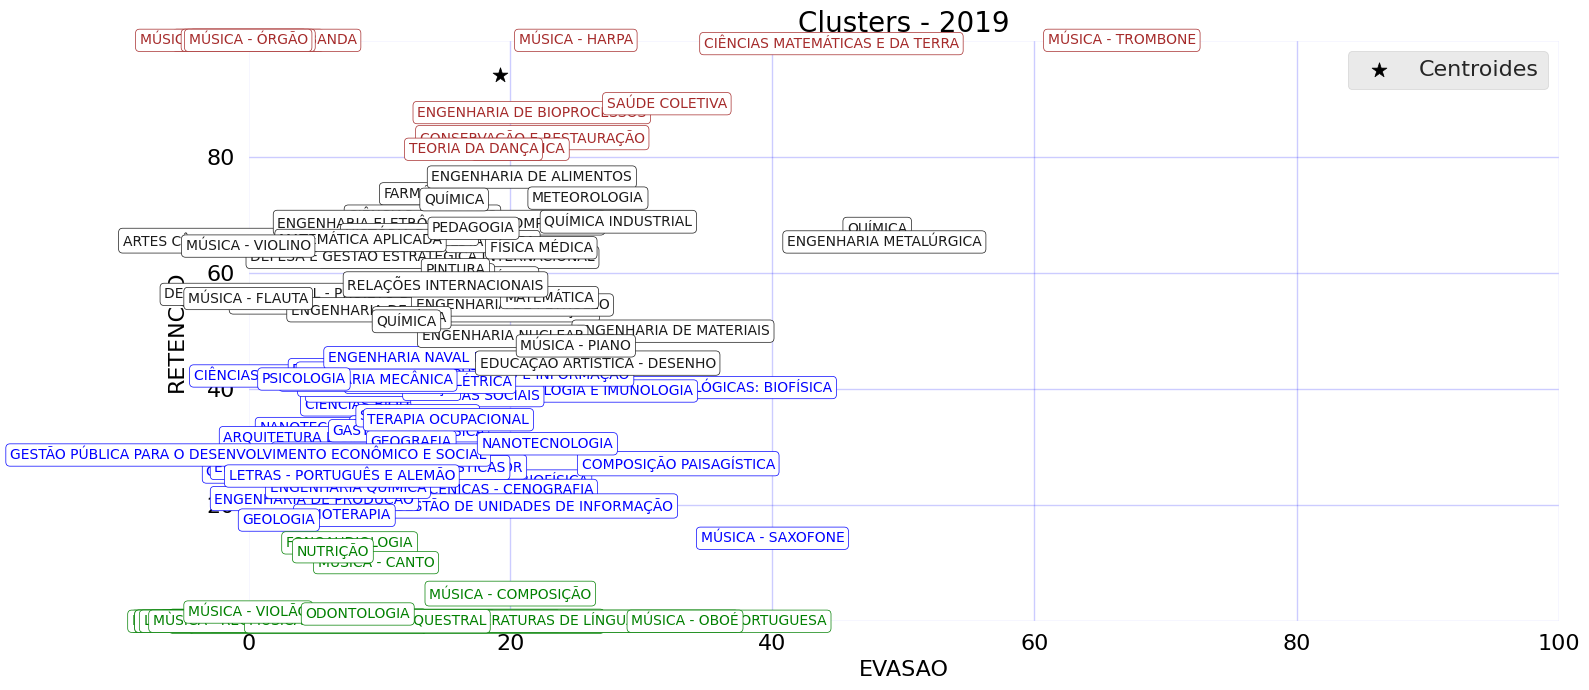

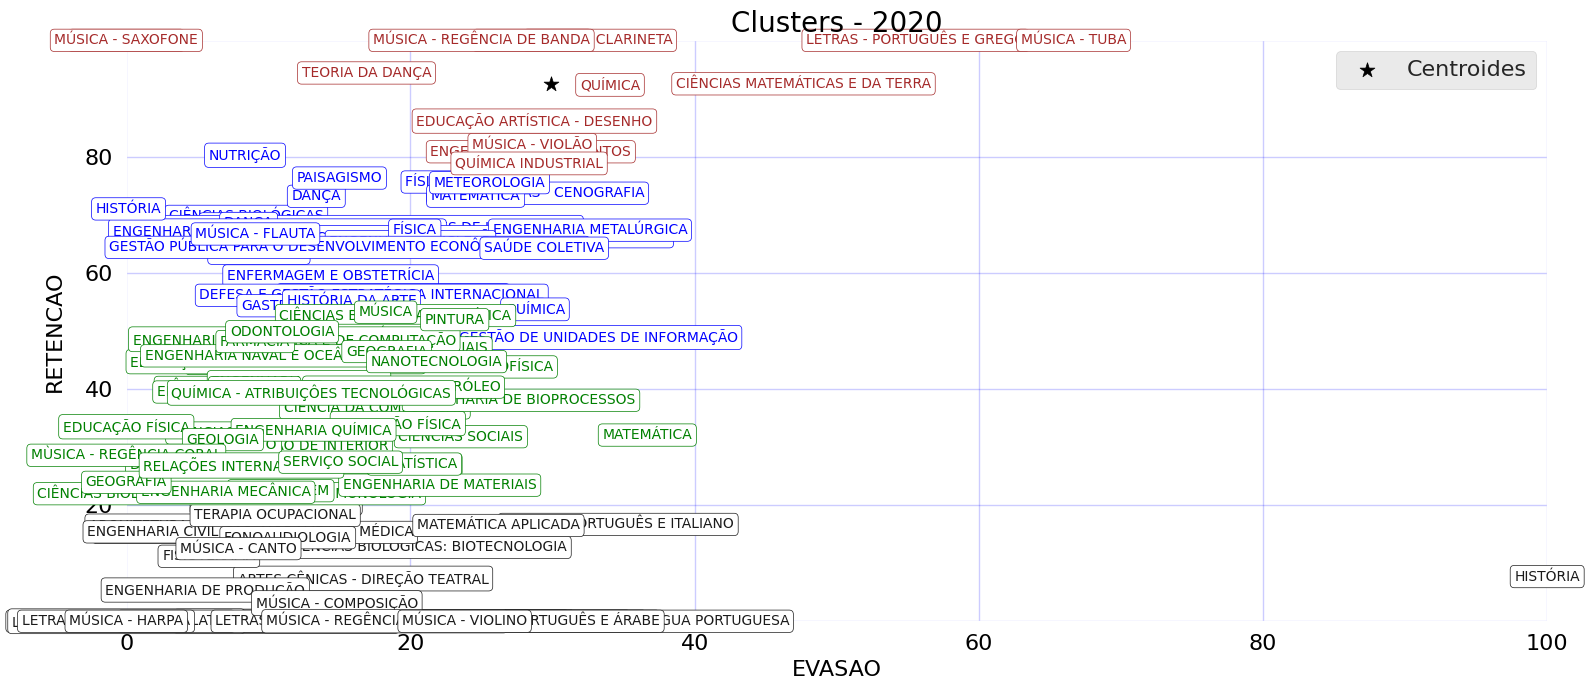

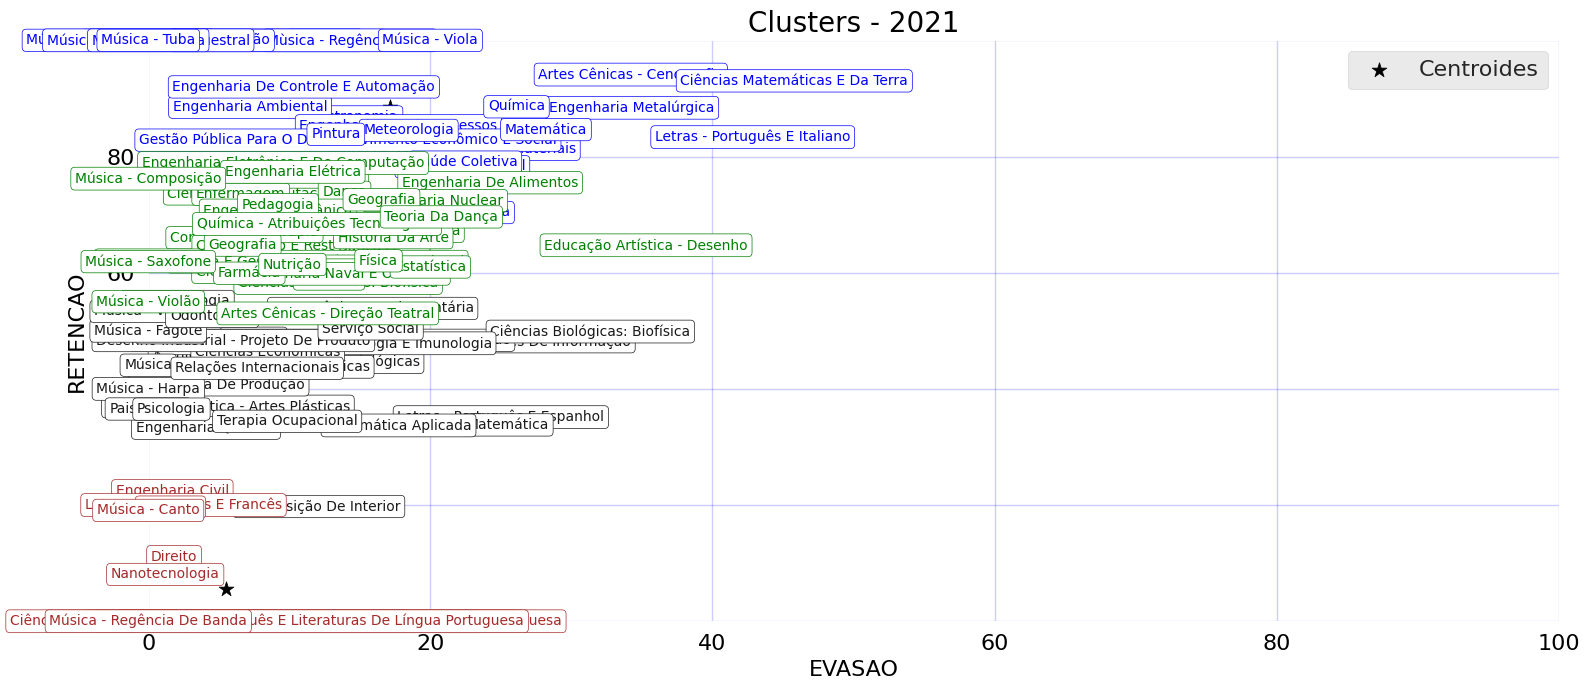

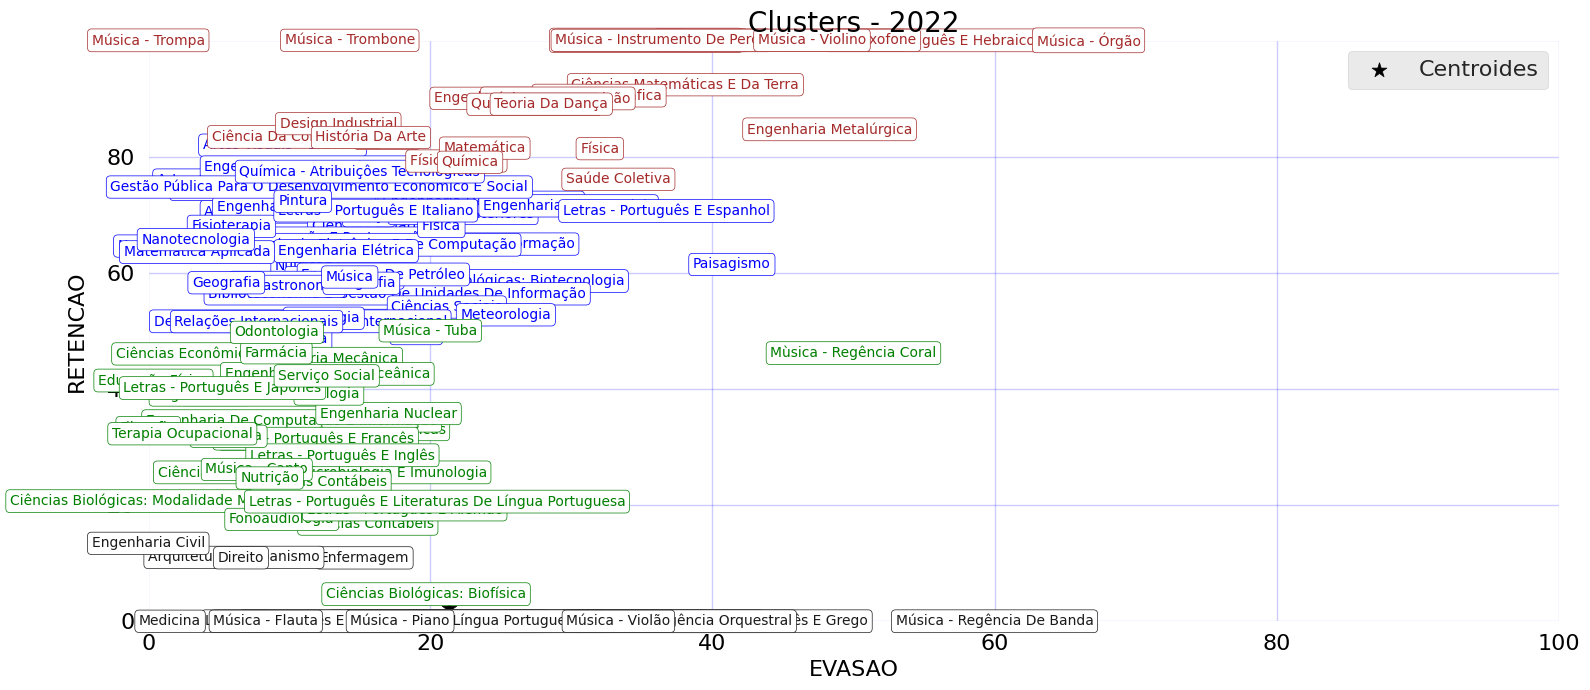

In [ ]:
for dfi, ano in zip([df15,df16,df17,df18,df19,df20,df21,df22,d23],range(2015,2024)):

  data = dfi.loc[:,['CO_CURSO','NO_CURSO','EVASAO','RETENCAO', 'SUCESSO']].set_index('CO_CURSO')
  fig, ax = plt.subplots(figsize=(16, 7))

  km = KMeans(n_clusters=4, random_state=42, n_init=10).fit(data[['EVASAO','RETENCAO','SUCESSO']])  # k = 4
  x, y = data['EVASAO'], data['RETENCAO']
  cores = ['blue', 'k', 'green', 'brown']

  # Pegar os centróides do KMeans
  centroids = km.cluster_centers_

  # Plotar os centróides
  ax.scatter(
      centroids[:, 0], centroids[:, 1],
      c='black', s=125, marker='*', label='Centroides'
  )

  # Substituir os pontos pelos nomes dos cursos
  cursos = data['NO_CURSO']  # Supondo que os nomes dos cursos estão nesta coluna
  for i in range(4):
      mask = km.labels_ == i
      for xi, yi, nome in zip(x[mask], y[mask], cursos[mask]):
          ax.annotate(
              nome, (xi, yi),
              color=cores[i], fontsize=10, ha='center', va='center',
              bbox=dict(facecolor='white', edgecolor=cores[i], boxstyle='round,pad=0.3')
          )

  # Configurações adicionais
  ax.set_xlim(0, 100)  # Limite do eixo X
  ax.set_ylim(0, 100)
  ax.set_xlabel('EVASAO', fontsize=16, color="black")
  ax.set_ylabel('RETENCAO', fontsize=16, color='black')
  ax.tick_params(axis='both', labelsize=16, labelcolor='black')  # Números em preto
  fig.patch.set_facecolor('white')  # Fundo branco para a figura
  ax.set_facecolor('white')  # Fundo branco para os eixos
  ax.grid(True, linestyle='-', alpha=0.2, color='blue')
  ax.set_title(f'Clusters - {ano}', fontsize=20, color='black')
  ax.legend(fontsize=16)  # Legenda com nomes personalizados
  plt.tight_layout()

  # Salvar o gráfico como PDF
  #plt.savefig(f'cursos_cluster_{ano}.pdf')
  plt.show()

## EVASAO-RETENCAO-SUCESSO-POR CENTRO

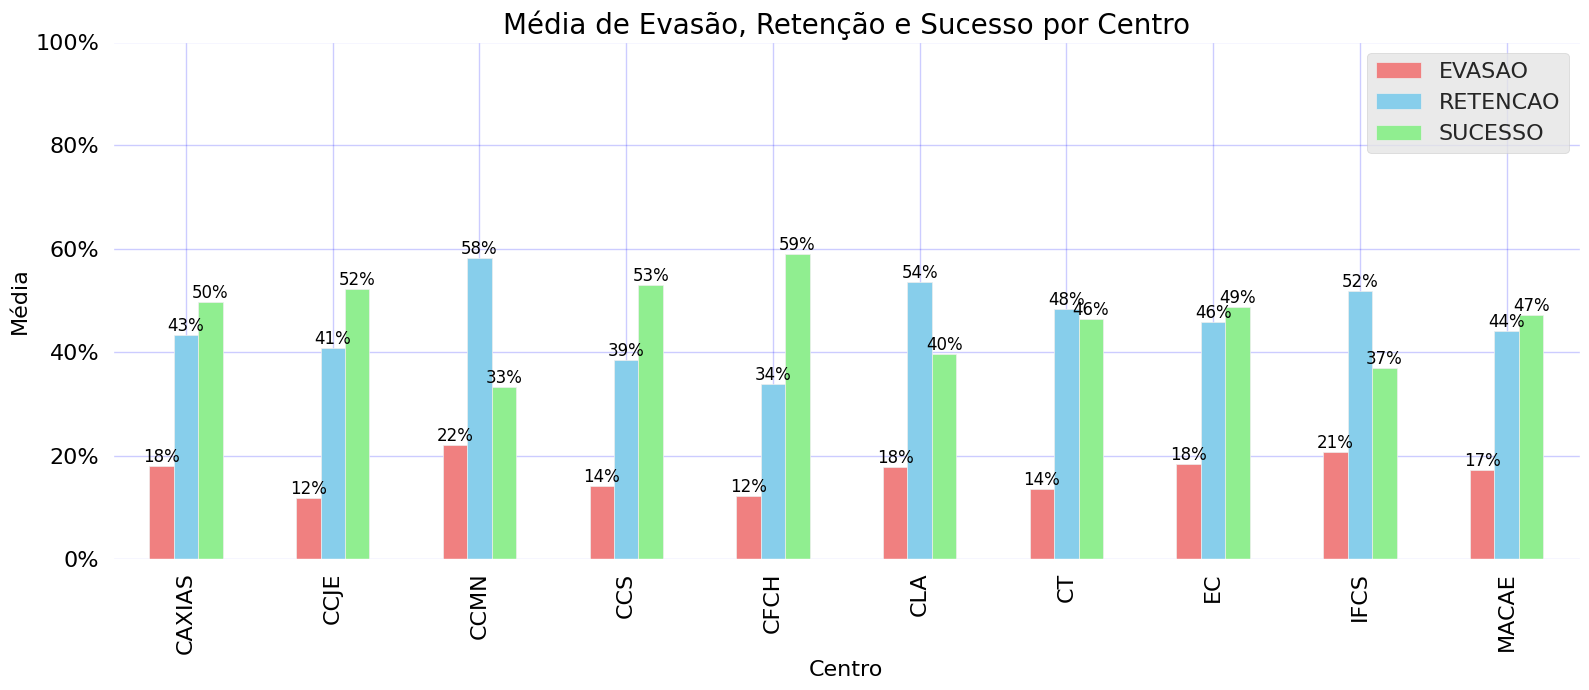

In [ ]:
data_centros = df_agp.groupby('CENTRO').agg({'EVASAO': 'mean', 'RETENCAO': 'mean', 'SUCESSO': 'mean'}).reset_index()

# Plotar o gráfico de barras
ax = data_centros.plot(
    kind='bar',
    x='CENTRO',
    y=['EVASAO', 'RETENCAO', 'SUCESSO'],
    figsize=(16, 7),
    color=['lightcoral', 'skyblue', 'lightgreen']
)

# Adicionar rótulos nas barras
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f%%', label_type='edge', fontsize=12, color='black')

# Definir os ticks do eixo y (de 0% a 100%)
ticks_y = np.arange(0, 120, 20)
ax.set_yticks(ticks_y)  # Definir as posições dos ticks no eixo y
ax.set_yticklabels([f'{int(t)}%' for t in ticks_y])  # Definir os rótulos como porcentagens

# Ajustes no layout
plt.tight_layout()
ax.tick_params(axis='both', labelsize=16, labelcolor='black')  # Ajuste do tamanho e cor dos números
fig = plt.gcf()  # Obter a figura associada aos eixos
fig.patch.set_facecolor('white')  # Fundo branco para a figura
ax.set_facecolor('white')  # Fundo branco para os eixos
ax.grid(True, linestyle='-', alpha=0.2, color='blue')

# Definir rótulos e título
ax.set_xlabel('Centro', fontsize=16, color='black')
ax.set_ylabel('Média', fontsize=16, color='black')
ax.set_title('Média de Evasão, Retenção e Sucesso por Centro', fontsize=20, color='black')
ax.legend(fontsize=16)

# Ajuste final do layout
plt.tight_layout()
plt.savefig('media_geral_eva_ret_suc_centros.pdf')
plt.show()

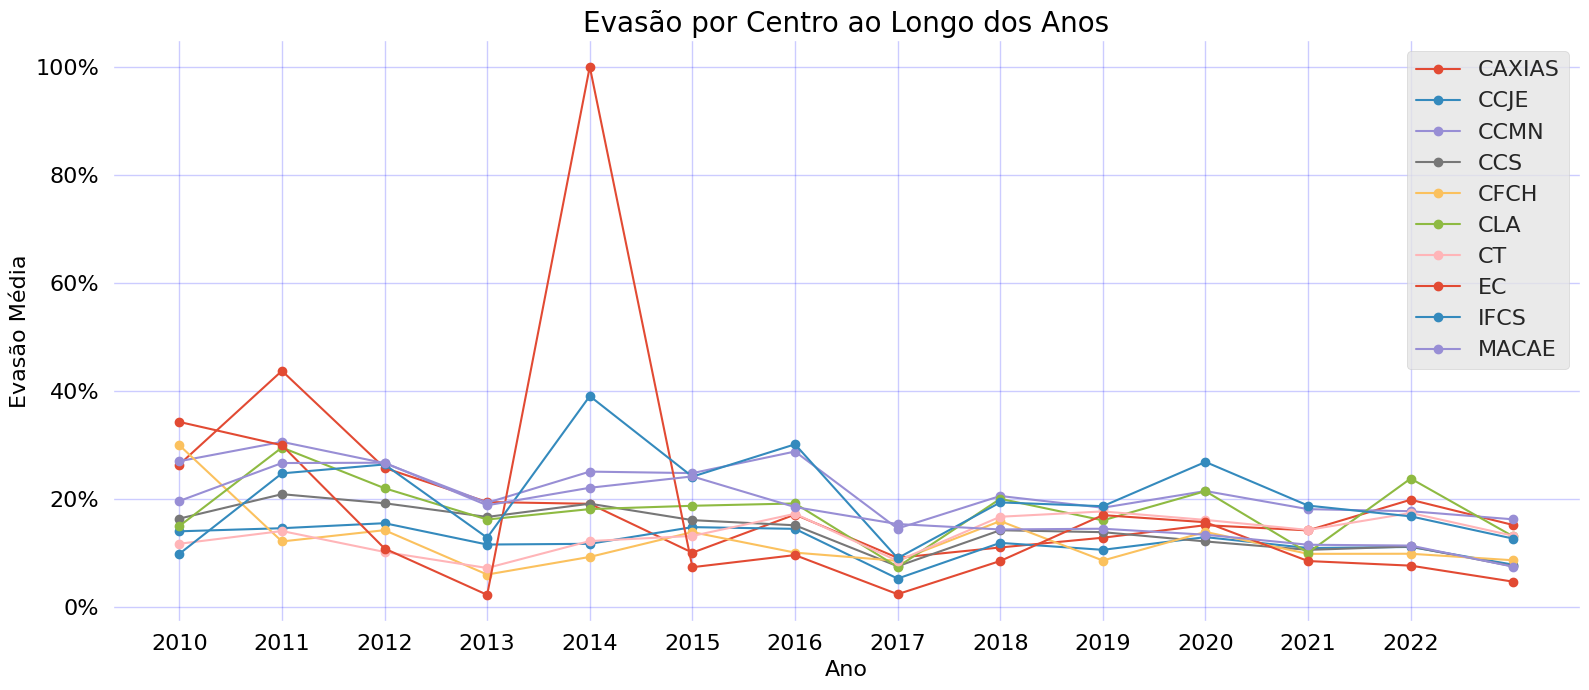

In [ ]:

data_evasao_ano = df_agp.groupby(['CENTRO', 'NU_ANO_CENSO']).agg({'EVASAO': 'mean'}).reset_index()

# Plotar o gráfico de barras
fig, ax = plt.subplots(figsize=(16, 7))

# Criar barras para cada ano de evasão por centro
for centro in data_evasao_ano['CENTRO'].unique():
    data_ano = data_evasao_ano[data_evasao_ano['CENTRO'] == centro]
    ax.plot(data_ano['NU_ANO_CENSO'], data_ano['EVASAO'], label=centro, marker='o')

# Adicionar rótulos nas barras
ax.set_yticks(np.arange(0, 120, 20))
ax.set_yticklabels([f'{int(t)}%' for t in np.arange(0, 120, 20)])
ax.set_xticks(np.arange(2010, 2023, 1))

# Ajustes no layout
ax.tick_params(axis='both', labelsize=16, labelcolor='black')
fig.patch.set_facecolor('white')  # Fundo branco para a figura
ax.set_facecolor('white')  # Fundo branco para os eixos
ax.grid(True, linestyle='-', alpha=0.2, color='blue')

# Definir rótulos e título
ax.set_xlabel('Ano', fontsize=16, color='black')
ax.set_ylabel('Evasão Média', fontsize=16, color='black')
ax.set_title('Evasão por Centro ao Longo dos Anos', fontsize=20, color='black')
ax.legend(fontsize=16)

# Ajuste final do layout
plt.tight_layout()
plt.savefig('evasao_por_ano_por_centro.pdf')
plt.show()